<a href="https://colab.research.google.com/github/simonamador/EEG-Channel-Selection-Algorithm/blob/main/lockedin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# P300 analysis on LIS patients
Working with a dataset of two subject, which consists of 4 registers each:


*   2 low accuracy signals
*   2 high accuracy signals


The data aquisition was done with a 256 Hz sample rate. 3 conditions indicated by trigger data:


1.   Distractor (-1)
2.   Nontarget (1)
3.   Target (2)

# Importing dataset, package installation

In [2]:
!pip install mne
from google.colab import drive
drive.mount('/content/drive')
import mne
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers
from scipy.io import loadmat
from time import sleep

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 15.3 MB/s eta 0:00:00
Mounted at /content/drive


In [3]:
route = '/content/drive/MyDrive/BR41N.IO/files'
channels = ['Fz', 'C3', 'Cz', 'C4', 'CP1', 'CPz', 'CP2', 'Pz']
fs = 256
P1_low1 = loadmat(route+'/P1_low1.mat')
P1_low2 = loadmat(route+'/P1_low2.mat')
P1_high1 = loadmat(route+'/P1_high1.mat')
P1_high2 = loadmat(route+'/P1_high2.mat')
P2_low1 = loadmat(route+'/P2_low1.mat')
P2_low2 = loadmat(route+'/P2_low2.mat')
P2_high1 = loadmat(route+'/P2_high1.mat')
P2_high2 = loadmat(route+'/P2_high2.mat')

# Preprocessing



1.   Convert to Volts
2.   Remove offset
3.   Filtro pasa altas de 1 Hz
4.   Filtro ICA
5.   Segmentación
6.   Normalizacion


In [4]:
def preprocessing(raw, fs):
  info = mne.create_info(channels,fs,ch_types='eeg')
  infostim = mne.create_info(['STI'], fs, 'stim')

  data = raw['y'].transpose()/10**6
  data = data - np.mean(data)
  n_raw = mne.io.RawArray(data,info)
  n_raw = n_raw.copy().filter(l_freq=1, h_freq=None)

  ica = mne.preprocessing.ICA(n_components=8, random_state=97, max_iter=800)
  ica.fit(n_raw)
  ica.plot_sources(n_raw, show_scrollbars=False)
  sleep(2)
  compex = input('Components to exclude: ')
  compex = compex.split(', ')
  compex_f = [int(n) for n in compex]
  ica.exclude = compex_f

  n_raw.load_data()
  ica.apply(n_raw)
  n_raw.plot(duration=5,show=False)
  plt.show()

  chex = input('Channels to exclude: ')
  chex = chex.split(', ')
  n_raw.drop_channels(chex)
  n_raw.plot(duration=5,show=False)
  plt.show()

  trigger = raw['trig'].transpose()
  for i in range(trigger.size):
    if trigger[0,i] == -1:
      trigger[0,i] = 3
  
  stim_raw = mne.io.RawArray(trigger, infostim)
  n_raw.add_channels([stim_raw], force_update_info=True)

  #-1 = distractor, 1 = non-target, 2=target
  events = mne.find_events(n_raw, stim_channel='STI')
  epochs = mne.Epochs(n_raw, events, tmin=-0.1, tmax=0.6)

  epochs['1'].plot_image(picks='eeg', combine='mean')
  epochs['2'].plot_image(picks='eeg', combine='mean')
  epochs['3'].plot_image(picks='eeg', combine='mean')

  nontarget = epochs['1'].get_data()
  target = epochs['2'].get_data()
  dist = epochs['3'].get_data()
  return nontarget, target, dist

Creating RawArray with float64 data, n_channels=8, n_times=39656
    Range : 0 ... 39655 =      0.000 ...   154.902 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 sec)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s finished


Fitting ICA took 2.9s.
Creating RawArray with float64 data, n_channels=8, n_times=39656
    Range : 0 ... 39655 =      0.000 ...   154.902 secs
Ready.
Using matplotlib as 2D backend.


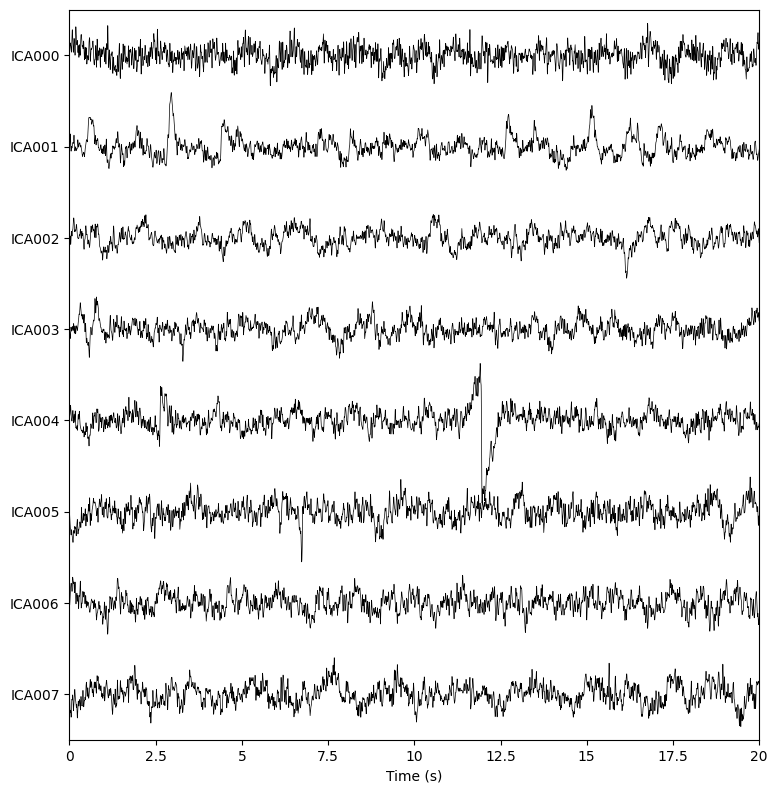

Components to exclude: 0, 4, 5
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 3 ICA components
    Projecting back using 8 PCA components


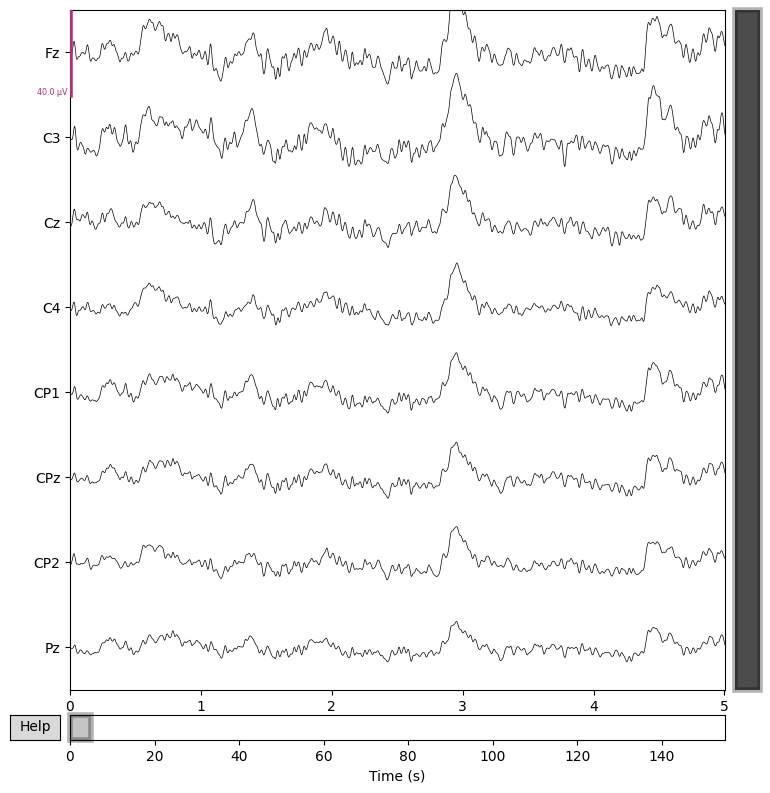

Channels to exclude: Pz


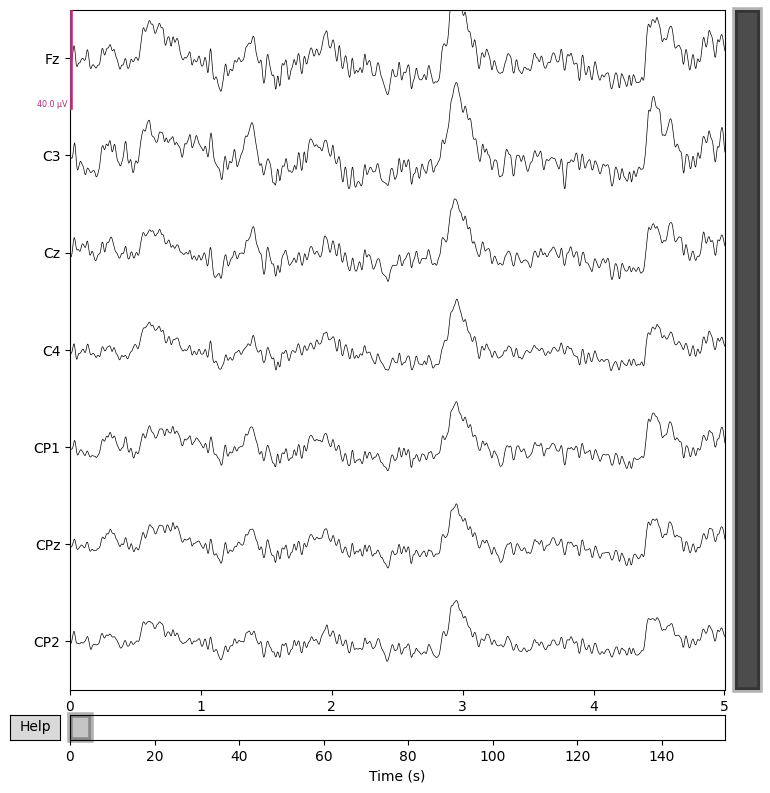

Creating RawArray with float64 data, n_channels=1, n_times=39656
    Range : 0 ... 39655 =      0.000 ...   154.902 secs
Ready.
480 events found
Event IDs: [1 2 3]
Not setting metadata
480 matching events found
Setting baseline interval to [-0.1015625, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 60 events and 181 original time points ...
0 bad epochs dropped
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


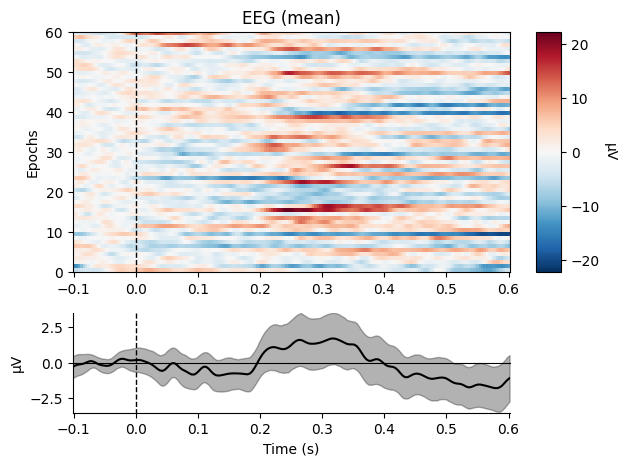

Using data from preloaded Raw for 60 events and 181 original time points ...
0 bad epochs dropped
Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


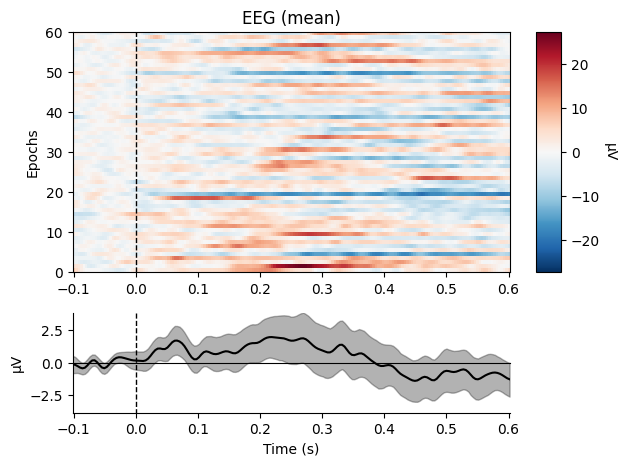

Using data from preloaded Raw for 360 events and 181 original time points ...
0 bad epochs dropped
Not setting metadata
360 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


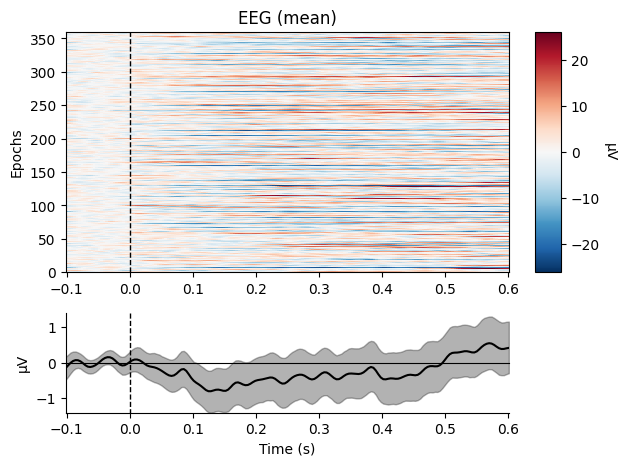

Using data from preloaded Raw for 60 events and 181 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 60 events and 181 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 360 events and 181 original time points ...
0 bad epochs dropped


In [5]:
nt, t, d = preprocessing(P2_high2, fs)

In [6]:
def minmax(X):
  scaler = sk.preprocessing.MinMaxScaler()
  for i in range(X.shape[0]):
    X[i,:,:] = scaler.fit_transform(X[i,:,:].transpose()).transpose()
  return X

In [7]:
Xt = t
Xnt = np.concatenate((nt,d))
Xt = minmax(Xt)
Xnt = minmax(Xnt)
yt = np.repeat(1,t.shape[0])
ynt = np.concatenate((np.repeat(0,nt.shape[0]),np.repeat(0,d.shape[0])))


sz = Xt.shape
#Generate matries for training-testing
X_tr = np.empty(shape=(round(sz[0]*1.6),sz[1],sz[2],1))
X_ts = np.empty(shape=(round(sz[0]*1.6),sz[1],sz[2],1))
#Use of permutation to randomly divide the matrix index,
#then divide feature and label matrices into training-testing
#in an 80/20 ratio. 
idx = np.random.permutation(sz[0])
idx_tr = idx[:round(sz[0]*0.8)]
idx_tst, idx_tsnt = idx[round(sz[0]*0.8):], np.random.permutation(int(sz[0]*1.4))
X_tr[:,:,:,0] = np.concatenate((Xt[idx_tr,:,:], Xnt[idx_tr,:,:]))
y_tr = np.concatenate((yt[idx_tr], ynt[idx_tr]))
X_ts[:,:,:,0] = np.concatenate((Xt[idx_tst,:,:], Xnt[idx_tsnt,:,:]))
y_ts = np.concatenate((yt[idx_tst],ynt[idx_tsnt]))

# Procesamiento

# LDA & Decission Forrest Classifier

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

Xtrain = np.zeros((X_tr.shape[0], X_tr.shape[1]*X_tr.shape[2]))
Xtest = np.zeros((X_ts.shape[0], X_ts.shape[1]*X_ts.shape[2]))
for i in range(X_tr.shape[0]):
  v = X_tr[i,:,:,0].flatten()
  Xtrain[i,:] = v

for i in range(X_ts.shape[0]):
  v = X_ts[i,:,:,0].flatten()
  Xtest[i,:] = v


lda = LDA()
X_train = lda.fit(Xtrain, y_tr)
y_test = lda.predict(Xtest)

from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth=2, random_state=0)

classifier.fit(Xtrain, y_tr)
y_pred = classifier.predict(Xtest)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm1 = confusion_matrix(y_ts, y_test)
print(cm1)
print('Accuracy' + str(accuracy_score(y_ts, y_test)))

cm2 = confusion_matrix(y_ts, y_pred)
print(cm2)
print('Accuracy' + str(accuracy_score(y_ts, y_pred)))

[[60 24]
 [ 1 11]]
Accuracy0.7395833333333334
[[62 22]
 [ 1 11]]
Accuracy0.7604166666666666


MLP classifier

In [9]:
tf.random.set_seed(42)
MLP = models.Sequential([
    layers.Flatten(),
    layers.Dense(10, activation='linear'),
    layers.Dense(10, activation='linear'),
    layers.Dense(2, activation='softmax')
    ])

MLP.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])
history = MLP.fit(X_tr, y_tr, epochs=10, 
                  validation_data=(X_ts, y_ts))
test_loss, test_acc = MLP.evaluate(X_ts,  y_ts, verbose=2)

Epoch 1/10
3/3 [==============================] - 1s 124ms/step - loss: 0.7058 - accuracy: 0.5625 - val_loss: 0.5004 - val_accuracy: 0.7604
Epoch 2/10
3/3 [==============================] - 0s 27ms/step - loss: 0.6717 - accuracy: 0.6042 - val_loss: 0.9162 - val_accuracy: 0.3125
Epoch 3/10
3/3 [==============================] - 0s 25ms/step - loss: 0.6761 - accuracy: 0.5625 - val_loss: 0.5088 - val_accuracy: 0.8229
Epoch 4/10
3/3 [==============================] - 0s 26ms/step - loss: 0.6305 - accuracy: 0.6562 - val_loss: 0.7854 - val_accuracy: 0.4271
Epoch 5/10
3/3 [==============================] - 0s 23ms/step - loss: 0.6348 - accuracy: 0.6354 - val_loss: 0.7491 - val_accuracy: 0.5208
Epoch 6/10
3/3 [==============================] - 0s 21ms/step - loss: 0.6597 - accuracy: 0.6042 - val_loss: 0.5031 - val_accuracy: 0.8229
Epoch 7/10
3/3 [==============================] - 0s 19ms/step - loss: 0.5945 - accuracy: 0.6667 - val_loss: 0.7718 - val_accuracy: 0.5000
Epoch 8/10
3/3 [==========

CNN classifier

In [10]:
tf.random.set_seed(42)
CNN = models.Sequential([
    layers.Conv2D(3, (2,2), activation='relu', input_shape=(X_tr.shape[1],X_tr.shape[2],1)),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(10, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(2, activation='softmax')
    ])

CNN.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])
history = CNN.fit(X_tr, y_tr, epochs=10, 
                  validation_data=(X_ts, y_ts))
test_loss, test_acc = CNN.evaluate(X_ts,  y_ts, verbose=2)

Epoch 1/10
3/3 [==============================] - 1s 137ms/step - loss: 0.6934 - accuracy: 0.4375 - val_loss: 0.6940 - val_accuracy: 0.3333
Epoch 2/10
3/3 [==============================] - 0s 35ms/step - loss: 0.6919 - accuracy: 0.5625 - val_loss: 0.6852 - val_accuracy: 0.8333
Epoch 3/10
3/3 [==============================] - 0s 36ms/step - loss: 0.6917 - accuracy: 0.5104 - val_loss: 0.6748 - val_accuracy: 0.8646
Epoch 4/10
3/3 [==============================] - 0s 35ms/step - loss: 0.6906 - accuracy: 0.5208 - val_loss: 0.6756 - val_accuracy: 0.8542
Epoch 5/10
3/3 [==============================] - 0s 37ms/step - loss: 0.6880 - accuracy: 0.5729 - val_loss: 0.6775 - val_accuracy: 0.7917
Epoch 6/10
3/3 [==============================] - 0s 35ms/step - loss: 0.6872 - accuracy: 0.5938 - val_loss: 0.6741 - val_accuracy: 0.7917
Epoch 7/10
3/3 [==============================] - 0s 38ms/step - loss: 0.6843 - accuracy: 0.5938 - val_loss: 0.6781 - val_accuracy: 0.6979
Epoch 8/10
3/3 [==========